In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/cropped_images_zip/cropped_training_images.zip'

In [4]:
# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250,250,3))

# Freeze the pre-trained weights
base_model.trainable = False

# Define the input shape
input_shape = (250, 250, 3)

# Define the input layer
# inputs = tf.keras.layers.Input(shape=input_shape)

# Pass the input layer through the pre-trained model
features = base_model.output

# Add a dense layer for multi-class classification
# outputs = tf.keras.layers.Dense(units=8, activation='sigmoid')(features)

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dense(units=8, activation='sigmoid')(outputs)

219055592/219055592 [==============================] - 1s 0us/step


In [4]:
# !pip install tensorflow_addons
import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1_score = tfa.metrics.F1Score(num_classes=8
                               )

In [6]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='binary_crossentropy',
              metrics=['accuracy', precision , recall, f1_score])

In [ ]:
model.summary()


In [8]:
# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
# base_path = 'C:/Users/User/DeepLearning/DL-Project'
# left_df = pd.read_excel(f'{base_path}/updated_left_eye.xlsx')
# right_df = pd.read_excel(f'{base_path}/updated_right_eye.xlsx')

# #concating both dataframes
# df = pd.concat([left_df, right_df], axis=0)


# # Split the data into two arrays, one for the image paths and one for the labels
# images_base_path = 'E:/odir-dataset/ODIR-5K/ODIR-5K/cropped_training_images/'
# image_paths = images_base_path + df["Fundus"].values
# labels = df.iloc[:, 3:].values

# # Convert the lists to tensors
# image_paths = tf.constant(image_paths)
# labels = tf.constant(labels)

# # Create a dataset from the image paths and labels
# dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [9]:
# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = 'C:/Users/User/DeepLearning/DL-Project'
left_df = pd.read_excel(f'{base_path}/updated_left_eye.xlsx')
right_df = pd.read_excel(f'{base_path}/updated_right_eye.xlsx')

#concating both dataframes
df = pd.concat([left_df, right_df], axis=0)


# Split the data into two arrays, one for the image paths and one for the labels
images_base_path = 'E:/odir-dataset/ODIR-5K/ODIR-5K/cropped_training_images/'
image_paths = images_base_path + df["Fundus"].values
labels = df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [10]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [250, 250])
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
dataset = dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [11]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [12]:
def split_data(dataset, train_split, test_split, val_split):
    # Calculate the size of each split
    dataset_size = dataset.reduce(tf.constant(0, dtype=tf.int64), lambda acc, _: acc + 1).numpy()
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)
    test_size = int(dataset_size * test_split)

    # Shuffle the elements of the dataset randomly
    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Split the dataset into train, validation, and test sets
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)
    return train_dataset, test_dataset, val_dataset

In [13]:
# Split the data into training and validation sets
train_dataset, test_dataset, val_dataset = split_data(dataset, train_split=0.7, test_split=0.15, val_split=0.15)

In [14]:
# Train the model
history=model.fit(train_dataset, epochs=50, batch_size=batch_size, validation_data=test_dataset)

Epoch 1/50
152/152 [==============================] - 150s 864ms/step - loss: 0.3316 - accuracy: 0.4477 - precision: 0.4825 - recall: 0.3111 - f1_score: 0.3145 - val_loss: 0.2656 - val_accuracy: 0.5593 - val_precision: 0.5875 - val_recall: 0.4524 - val_f1_score: 0.4384
Epoch 2/50
152/152 [==============================] - 130s 819ms/step - loss: 0.2680 - accuracy: 0.5455 - precision: 0.5960 - recall: 0.3994 - f1_score: 0.4302 - val_loss: 0.2402 - val_accuracy: 0.5901 - val_precision: 0.6536 - val_recall: 0.3980 - val_f1_score: 0.5377
Epoch 3/50
152/152 [==============================] - 129s 813ms/step - loss: 0.2430 - accuracy: 0.5818 - precision: 0.6469 - recall: 0.4467 - f1_score: 0.5092 - val_loss: 0.2216 - val_accuracy: 0.6112 - val_precision: 0.6445 - val_recall: 0.5692 - val_f1_score: 0.4867
Epoch 4/50
152/152 [==============================] - 130s 820ms/step - loss: 0.2271 - accuracy: 0.6194 - precision: 0.6782 - recall: 0.4864 - f1_score: 0.5490 - val_loss: 0.2091 - val_accur

In [15]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v4.h5')

In [16]:
import matplotlib.pyplot as plt

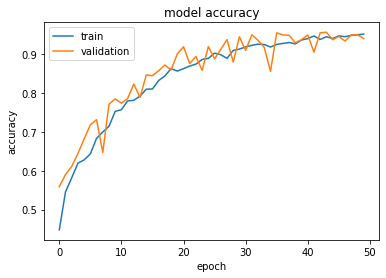

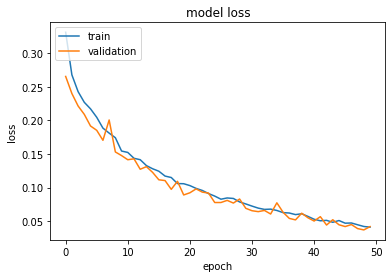

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v4.h5')

In [19]:
base_learning_rate = 0.0001
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='binary_crossentropy',
              metrics=['accuracy', precision , recall, f1_score])

In [20]:
new_history=new_model.fit(train_dataset, epochs=25, batch_size=batch_size, validation_data=test_dataset)

Epoch 1/25
152/152 [==============================] - 156s 911ms/step - loss: 0.0459 - accuracy: 0.9423 - precision: 0.9753 - recall: 0.9612 - f1_score: 0.9503 - val_loss: 0.0451 - val_accuracy: 0.9540 - val_precision: 0.9493 - val_recall: 0.9932 - val_f1_score: 0.9514
Epoch 2/25
152/152 [==============================] - 142s 893ms/step - loss: 0.0401 - accuracy: 0.9495 - precision: 0.9878 - recall: 0.9726 - f1_score: 0.9590 - val_loss: 0.0401 - val_accuracy: 0.9301 - val_precision: 0.9818 - val_recall: 0.9692 - val_f1_score: 0.9577
Epoch 3/25
152/152 [==============================] - 139s 878ms/step - loss: 0.0380 - accuracy: 0.9543 - precision: 0.9890 - recall: 0.9816 - f1_score: 0.9623 - val_loss: 0.0370 - val_accuracy: 0.9375 - val_precision: 0.9922 - val_recall: 0.9795 - val_f1_score: 0.9597
Epoch 4/25
152/152 [==============================] - 140s 883ms/step - loss: 0.0390 - accuracy: 0.9574 - precision: 0.9859 - recall: 0.9779 - f1_score: 0.9593 - val_loss: 0.0351 - val_accur

In [21]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v6.h5')

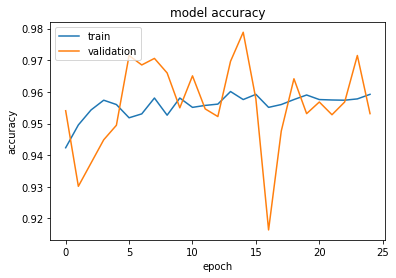

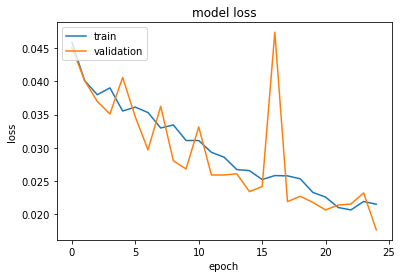

In [22]:
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
predictions = model.predict(val_dataset, batch_size=32)

32/32 [==============================] - 31s 660ms/step


In [28]:
predictions[0]

array([1.19603239e-01, 4.96491976e-02, 4.95992927e-03, 3.68840392e-06,
       2.21214145e-06, 1.16128795e-05, 7.55629517e-11, 8.65907848e-01],
      dtype=float32)

In [27]:
type(predictions)

numpy.ndarray

In [31]:
type(val_dataset)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [5]:
model = tf.keras.models.load_model('C:/Users/User/DeepLearning/DL-Project/models/model_2_v4.h5')

In [14]:
evaluation = model.evaluate(val_dataset, return_dict=True)

32/32 [==============================] - 210s 4s/step - loss: 0.0394 - accuracy: 0.9434 - precision: 0.9747 - recall: 0.9827 - f1_score: 0.9627


In [17]:
evaluation

{'loss': 0.039367564022541046,
 'accuracy': 0.943359375,
 'precision': 0.9747064113616943,
 'recall': 0.9826958179473877,
 'f1_score': array([0.98615545, 0.8979592 , 0.9879518 , 1.        , 0.9677419 ,
        0.95238096, 1.        , 0.90909094], dtype=float32)}

In [18]:
predictions = model.predict(val_dataset)

32/32 [==============================] - 206s 4s/step


In [19]:
predictions

array([[8.89644206e-01, 2.47993432e-02, 9.48843493e-09, ...,
        7.18332303e-04, 6.99732286e-12, 3.84062715e-02],
       [1.70370657e-02, 4.61048301e-04, 2.73906771e-04, ...,
        1.19165335e-07, 1.73161330e-04, 4.41459343e-02],
       [9.96516824e-01, 1.17223449e-02, 6.05624009e-05, ...,
        1.12883245e-05, 3.45241666e-08, 1.02970726e-03],
       ...,
       [5.22890361e-03, 8.74812424e-01, 5.62200614e-04, ...,
        1.18865480e-03, 1.09431252e-03, 3.49005051e-02],
       [9.91101146e-01, 3.49007435e-02, 4.67241216e-06, ...,
        5.62971309e-07, 4.98221588e-08, 1.33236628e-02],
       [9.17368680e-02, 2.42757499e-01, 4.58416025e-06, ...,
        9.87865150e-01, 2.20343566e-08, 9.27157886e-03]], dtype=float32)

In [21]:
# Define an iterator
iterator = iter(val_dataset)

# Use the `next` function to access the elements of the dataset
for i in range(len(val_dataset)):
    value = next(iterator)
    print(value)

(<tf.Tensor: shape=(32, 250, 250, 3), dtype=float32, numpy=
array([[[[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        ...,

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1.,

(<tf.Tensor: shape=(32, 250, 250, 3), dtype=float32, numpy=
array([[[[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        ...,

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1.,